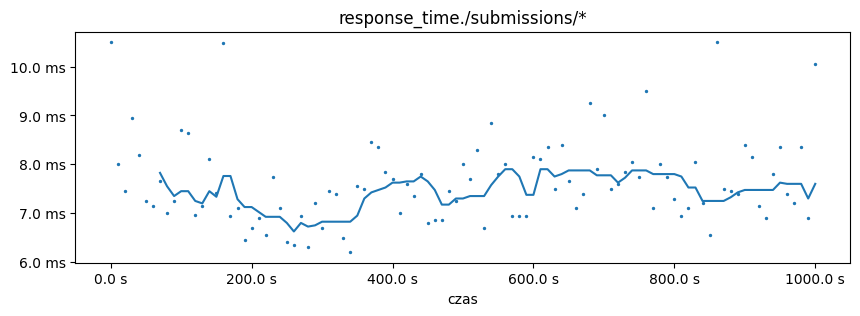

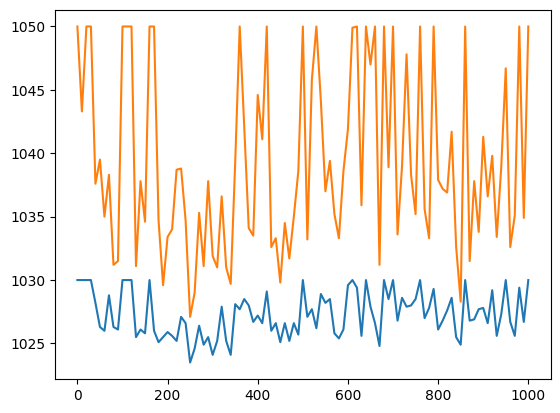

[(0.0, {'min': 1087.4, 'max': 1090.3, 'count': 2, 'mean': 1088.9, 'p50': 1085.9, 'median': 1085.9, 'p75': 1085.9, 'p90': 1085.9, 'p95': 1085.9, 'p99': 1085.9, 'p999': 1085.9}), (10.0, {'min': 1022.8, 'max': 1043.3, 'count': 21, 'mean': 1032.3, 'p50': 1043.3, 'median': 1043.3, 'p75': 1043.3, 'p90': 1043.3, 'p95': 1043.3, 'p99': 1043.3, 'p999': 1043.3}), (20.0, {'min': 1022.7, 'max': 2044.6, 'count': 20, 'mean': 1079.2, 'p50': 1022.7, 'median': 1022.7, 'p75': 1022.7, 'p90': 1043.3, 'p95': 1043.3, 'p99': 1043.3, 'p999': 1043.3}), (30.0, {'min': 1019, 'max': 1054.1, 'count': 20, 'mean': 1031.7, 'p50': 1022.7, 'median': 1022.7, 'p75': 1022.7, 'p90': 1043.3, 'p95': 1043.3, 'p99': 1043.3, 'p999': 1043.3}), (40.0, {'min': 1021.9, 'max': 1037.6, 'count': 20, 'mean': 1028.2, 'p50': 1022.7, 'median': 1022.7, 'p75': 1022.7, 'p90': 1022.7, 'p95': 1022.7, 'p99': 1022.7, 'p999': 1022.7}), (50.0, {'min': 1021, 'max': 1039.5, 'count': 20, 'mean': 1026.3, 'p50': 1022.7, 'median': 1022.7, 'p75': 1022.7, 

In [99]:
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker 
import pandas as pd

with open('./results/c.json') as f:
    data = json.load(f)

batches = data['intermediate']

SUBMISSION_METRIC_PREFIX = 'plugins.metrics-by-endpoint./submissions/'

def count_submission_gets(metrics):
    get_submission_count = 0
    for metric in metrics:
        if (metric.startswith(SUBMISSION_METRIC_PREFIX)):
            get_submission_count += 1
    return get_submission_count

def gather_get_submission_response_times(metrics):
    return [metric['min'] for metric in metrics]

start_timestamp = batches[0]['period']
results = []

for batch in batches:
    time = (int(batch['period']) - int(start_timestamp)) / 1000
    data = {}
    counters = batch['counters']
    histograms = batch['histograms']

    data['GET-' + SUBMISSION_METRIC_PREFIX + '*'] = count_submission_gets(counters)
    data['POST-' + 'plugins.metrics-by-endpoint.response_time./submissions'] = histograms['plugins.metrics-by-endpoint.response_time./submissions']
    data['vusers.session_length'] = histograms['vusers.session_length']

    response_time_metrics = [histograms[metric] for metric in histograms.keys() if metric.startswith('plugins.metrics-by-endpoint.response_time./submissions/')]
    data['plugins.metrics-by-endpoint.response_time./submissions/*'] = gather_get_submission_response_times(response_time_metrics)

    results.append((time, data))

plt.figure(figsize=(10, 3))

response_times = [(result[0], result[1]['plugins.metrics-by-endpoint.response_time./submissions/*']) for result in results]

x = [response[0] for response in response_times]
y = [np.average(response[1]) for response in response_times]

df = pd.DataFrame(y)

y_roll = df.rolling(window=8).median()

plt.scatter(x, y, s=2)
plt.plot(x, y_roll)
plt.title('response_time./submissions/*')
plt.gca().yaxis.set_major_formatter(mticker.FormatStrFormatter('%.1f ms'))
plt.gca().xaxis.set_major_formatter(mticker.FormatStrFormatter('%.1f s'))
plt.xlabel("czas")
plt.show()

# --------------------

session_length = [(result[0], result[1]['vusers.session_length']) for result in results]

x = [session[0] for session in session_length]

y_min = [session[1]["mean"] for session in session_length]
df_min = pd.DataFrame(y_min)
y_min_roll = df.rolling(window=3).mean()

y_max = [session[1]["max"] for session in session_length]
df_max = pd.DataFrame(y_max)
y_max_roll = df.rolling(window=3).mean()

plt.plot(x, np.clip(y_min, 0, 1030))
plt.plot(x, np.clip(y_max, 0, 1050))
plt.show()

print(session_length)

